# Классификация фруктов (Logistic regression, SVM, Random Forest)


## Импорты


In [7]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

## Генерация данных


In [8]:
np.random.seed(42)
n_samples = 2000

fruits = [
    "apple",
    "orange",
    "banana",
    "grape",
    "kiwi",
    "papaya",
    "blueberry",
    "watermelon",
]

data = {"weight": [], "size": [], "color": [], "shape": [], "fruit": []}

for _ in range(n_samples):
    fruit = np.random.choice(fruits)
    data["fruit"].append(fruit)

    if fruit == "apple":
        data["weight"].append(np.random.normal(150, 20))  # 150g ± 20g
        data["size"].append(np.random.normal(7, 1))  # 7cm ± 1cm
        data["color"].append(np.random.choice(["red", "green", "yellow"]))
        data["shape"].append(np.random.choice(["round", "oval"]))
    elif fruit == "orange":
        data["weight"].append(np.random.normal(200, 30))
        data["size"].append(np.random.normal(8, 1.5))
        data["color"].append(np.random.choice(["orange", "yellow"]))
        data["shape"].append(np.random.choice(["round", "oval"]))
    elif fruit == "banana":
        data["weight"].append(np.random.normal(120, 15))
        data["size"].append(np.random.normal(10, 2))
        data["color"].append(np.random.choice(["yellow", "green"]))
        data["shape"].append(np.random.choice(["elongated"]))
    elif fruit == "grape":
        data["weight"].append(np.random.normal(5, 1))
        data["size"].append(np.random.normal(1, 0.5))
        data["color"].append(np.random.choice(["purple", "green", "red"]))
        data["shape"].append(np.random.choice(["round"]))
    elif fruit == "kiwi":
        data["weight"].append(np.random.normal(75, 10))
        data["size"].append(np.random.normal(5, 0.5))
        data["color"].append("brown")
        data["shape"].append(np.random.choice(["oval"]))
    elif fruit == "papaya":
        data["weight"].append(np.random.normal(1000, 100))
        data["size"].append(np.random.normal(30, 5))
        data["color"].append(np.random.choice(["yellow", "brown"]))
        data["shape"].append(np.random.choice(["oval", "elongated"]))
    elif fruit == "blueberry":
        data["weight"].append(np.random.normal(2, 0.5))
        data["size"].append(np.random.normal(1, 0.5))
        data["color"].append(np.random.choice(["blue", "purple"]))
        data["shape"].append(np.random.choice(["round"]))
    elif fruit == "watermelon":
        data["weight"].append(np.random.normal(5000, 500))
        data["size"].append(np.random.normal(50, 5))
        data["color"].append(np.random.choice(["green"]))
        data["shape"].append(np.random.choice(["round", "oval"]))

# Dataframe
df = pd.DataFrame(data)

df["weight"] = df["weight"].clip(lower=1)  # No negative weights
df["size"] = df["size"].clip(lower=1)  # No negative sizes

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display
print("Dataset Preview:")
display(df.head(10))

# Data summary
print("\nDataset Summary:")
display(df.describe())

# Save to CSV
df.to_csv("fruit_data.csv", index=False)
print("Dataset saved as 'fruit_data.csv'")

Dataset Preview:


,weight,size,color,shape,fruit
0,1109.210296,22.617682,brown,oval,papaya
1,2.200672,2.091254,purple,round,blueberry
2,60.711428,5.110942,brown,oval,kiwi
3,1035.600263,31.089987,yellow,oval,papaya
4,150.678016,5.958152,green,round,apple
5,1090.962113,28.115448,yellow,elongated,papaya
6,5977.078717,47.471266,green,round,watermelon
7,159.821321,7.988654,red,round,apple
8,149.902861,6.616677,yellow,round,apple
9,1.375302,1.000000,purple,round,blueberry



Dataset Summary:


,weight,size
count,2000.000000,2000.000000
mean,820.008177,14.152934
std,1616.310173,16.235024
min,1.000000,1.000000
25%,7.252889,2.117646
50%,132.939336,7.340206
75%,859.684198,20.928073
max,6747.938895,65.309735


Dataset saved as 'fruit_data.csv'


## Предварительная обработка данных (Preprocessing)

In [9]:
le_color = LabelEncoder()
le_shape = LabelEncoder()
le_fruit = LabelEncoder()

df = pd.read_csv("fruit_data.csv")
df["color"] = le_color.fit_transform(df["color"])
df["shape"] = le_shape.fit_transform(df["shape"])
df["fruit"] = le_fruit.fit_transform(df["fruit"])

print("Encoded Dataset Preview:")
display(df.head(10))

X = df[["weight", "size", "color", "shape"]]
y = df["fruit"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Encoded Dataset Preview:


,weight,size,color,shape,fruit
0,1109.210296,22.617682,1,1,6
1,2.200672,2.091254,4,2,2
2,60.711428,5.110942,1,1,4
3,1035.600263,31.089987,6,1,6
4,150.678016,5.958152,2,2,0
5,1090.962113,28.115448,6,0,6
6,5977.078717,47.471266,2,2,7
7,159.821321,7.988654,5,2,0
8,149.902861,6.616677,6,2,0
9,1.375302,1.000000,4,2,2


## Создание и тренировка моделей
Предвадительные результаты без оптимизаций гипер-параметров, без кросс-валидации

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1: Logistic Regression
lr = LogisticRegression(max_iter=10000, random_state=42)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
print("\nLogistic Regression Results:")
print(classification_report(y_test, lr_pred, target_names=le_fruit.classes_))

# Model 2: Support Vector Machine (SVM)
svm = SVC(kernel="rbf", random_state=42)  # RBF kernel for non-linear separation
svm.fit(X_train_scaled, y_train)
svm_pred = svm.predict(X_test_scaled)
print("\nSVM Results:")
print(classification_report(y_test, svm_pred, target_names=le_fruit.classes_))

# Model 3: Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)
print("\nRandom Forest Results:")
print(classification_report(y_test, rf_pred, target_names=le_fruit.classes_))


Logistic Regression Results:
              precision    recall  f1-score   support

       apple       0.73      0.22      0.34        50
      banana       1.00      1.00      1.00        48
   blueberry       0.55      0.46      0.50        50
       grape       0.61      0.72      0.66        58
        kiwi       1.00      1.00      1.00        48
      orange       0.51      0.89      0.65        45
      papaya       1.00      0.98      0.99        47
  watermelon       1.00      1.00      1.00        54

    accuracy                           0.78       400
   macro avg       0.80      0.78      0.77       400
weighted avg       0.80      0.78      0.77       400


SVM Results:
              precision    recall  f1-score   support

       apple       1.00      0.26      0.41        50
      banana       1.00      1.00      1.00        48
   blueberry       1.00      0.46      0.63        50
       grape       0.68      1.00      0.81        58
        kiwi       1.00      1.00 

## Отчет по результатам классификации фруктов

### Обзор результатов

Были протестированы три модели классификации на синтетическом наборе данных фруктов:

1. **Логистическая регрессия**

   - Accuracy: 0.78
   - Macro Avg F1-score: 0.77
   - Сильные стороны: Хорошо справилась с бананами, киви и арбузами (F1 = 1.00)
   - Слабые стороны: Низкая точность для яблок (recall = 0.22)

2. **Метод опорных векторов (SVM)**

   - Accuracy: 0.84
   - Macro Avg F1-score: 0.82
   - Сильные стороны: Отличные результаты по большинству классов, особенно по бананам, киви, папайе и арбузам (F1 = 1.00)
   - Слабые стороны: Проблемы с классификацией яблок (recall = 0.26)

3. **Случайный лес (Random Forest)**
   - Accuracy: 0.98
   - Macro Avg F1-score: 0.98
   - Сильные стороны: Превосходная производительность по всем классам (F1 ≥ 0.92)
   - Слабые стороны: Незначительные ошибки в классификации винограда и апельсинов

## Выводы

- **Лучшая модель**: Random Forest показал наилучшие результаты с точностью 98% и сбалансированными метриками по всем классам.
- **Сравнение моделей**:
  - Random Forest значительно превосходит другие модели благодаря своей способности обрабатывать нелинейные зависимости и взаимодействие признаков.
  - SVM показал средние результаты, улучшив точность по сравнению с логистической регрессией, но уступает Random Forest.
  - Логистическая регрессия оказалась наименее эффективной, особенно для классов с пересекающимися характеристиками (например, яблоки).
- **Рекомендации**: Для данной задачи рекомендуется использовать Random Forest из-за его высокой точности и устойчивости к вариациям в данных.


## Оптимизация гипер-параметров
Используется GridSearchCV для нахождения значений параметров которые наиболее оптимальны для классификации.

In [11]:
# Logistic Regression
lr_param_grid = {
    "C": [0.01, 0.1, 1.0, 10, 100],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"],  # 'liblinear' supports both l1 and l2
}

# SVM
svm_param_grid = {
    "C": [0.01, 0.1, 1.0, 10, 100],
    "gamma": [0.01, 0.1, 1.0, 10, 100],
    "kernel": ["rbf"],
}

# Random Forest
rf_param_grid = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
}

# Grid Search with 5-fold Cross-Validation
# Logistic Regression
lr_grid = GridSearchCV(
    LogisticRegression(max_iter=10000, random_state=42),
    lr_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)
lr_grid.fit(X_train_scaled, y_train)
print("\nBest Logistic Regression Parameters:", lr_grid.best_params_)
print("Best Cross-Validation Accuracy:", lr_grid.best_score_)
lr_best_pred = lr_grid.predict(X_test_scaled)
print("Tuned Logistic Regression Test Results:")
print(classification_report(y_test, lr_best_pred, target_names=le_fruit.classes_))

# SVM
# Updated SVM GridSearchCV to enable probabilities
svm_grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    svm_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)
svm_grid.fit(X_train_scaled, y_train)

print("\nBest SVM Parameters:", svm_grid.best_params_)
print("Best Cross-Validation Accuracy:", svm_grid.best_score_)
svm_best_pred = svm_grid.predict(X_test_scaled)
print("Tuned SVM Test Results:")
print(classification_report(y_test, svm_best_pred, target_names=le_fruit.classes_))

# Random Forest
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)
rf_grid.fit(X_train_scaled, y_train)
print("\nBest Random Forest Parameters:", rf_grid.best_params_)
print("Best Cross-Validation Accuracy:", rf_grid.best_score_)
rf_best_pred = rf_grid.predict(X_test_scaled)
print("Tuned Random Forest Test Results:")
print(classification_report(y_test, rf_best_pred, target_names=le_fruit.classes_))


Best Logistic Regression Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.8825
Tuned Logistic Regression Test Results:
              precision    recall  f1-score   support

       apple       0.76      0.26      0.39        50
      banana       1.00      1.00      1.00        48
   blueberry       0.96      0.90      0.93        50
       grape       0.92      0.97      0.94        58
        kiwi       0.98      1.00      0.99        48
      orange       0.51      0.91      0.65        45
      papaya       1.00      0.91      0.96        47
  watermelon       1.00      1.00      1.00        54

    accuracy                           0.87       400
   macro avg       0.89      0.87      0.86       400
weighted avg       0.90      0.87      0.86       400


Best SVM Parameters: {'C': 100, 'gamma': 100, 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9775
Tuned SVM Test Results:
              precision    recall  f1-score   support


# Отчет по результатам оптимизации гиперпараметров

## Сравнение моделей до и после оптимизации

### 1. Логистическая регрессия

- **Результаты до оптимизации:**

  - Точность (Accuracy): **0.78**
  - Средний F1-скор (Macro Avg F1-score): **0.77**
  - Проблемы с классификацией яблок (recall = 0.22).

- **Результаты после оптимизации:**
  - **Лучшие параметры:** `{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}`
  - Точность на кросс-валидации: **0.88**
  - Точность на тесте: **0.87**
  - Средний F1-скор: **0.86**
  - Улучшение классификации большинства классов, но яблоки остаются сложным классом (recall = 0.26).

---

### 2. Метод опорных векторов (SVM)

- **Результаты до оптимизации:**

  - Точность (Accuracy): **0.84**
  - Средний F1-скор (Macro Avg F1-score): **0.82**
  - Проблемы с классификацией яблок (recall = 0.26).

- **Результаты после оптимизации:**
  - **Лучшие параметры:** `{'C': 100, 'gamma': 100, 'kernel': 'rbf'}`
  - Точность на кросс-валидации: **0.98**
  - Точность на тесте: **0.97**
  - Средний F1-скор: **0.97**
  - Значительное улучшение классификации яблок (recall = 0.92) и общих результатов.

---

### 3. Случайный лес (Random Forest)

- **Результаты до оптимизации:**

  - Точность (Accuracy): **0.98**
  - Средний F1-скор (Macro Avg F1-score): **0.98**
  - Отличные результаты по всем классам.

- **Результаты после оптимизации:**
  - **Лучшие параметры:** `{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}`
  - Точность на кросс-валидации: **0.98**
  - Точность на тесте: **0.98**
  - Средний F1-скор: **0.98**
  - Существенных изменений не произошло, так как модель уже была хорошо настроена.

---

## Выводы

1. **Лучшая модель:** Случайный лес (Random Forest) остается лидером с точностью **98%** и сбалансированными метриками по всем классам.
2. **Улучшенная модель:** Метод опорных векторов (SVM) показал значительное улучшение после оптимизации гиперпараметров, достигнув точности **97%**.
3. **Выводы о моделях:**
   - Для использования в продакшене рекомендуется модель **Random Forest** из-за её стабильности и высокой точности.
   - **SVM** может быть альтернативой, если требуется более компактная модель с аналогичной производительностью.
   - Логистическая регрессия подходит для простых задач, но уступает другим моделям в данной задаче.


## ROC кривая

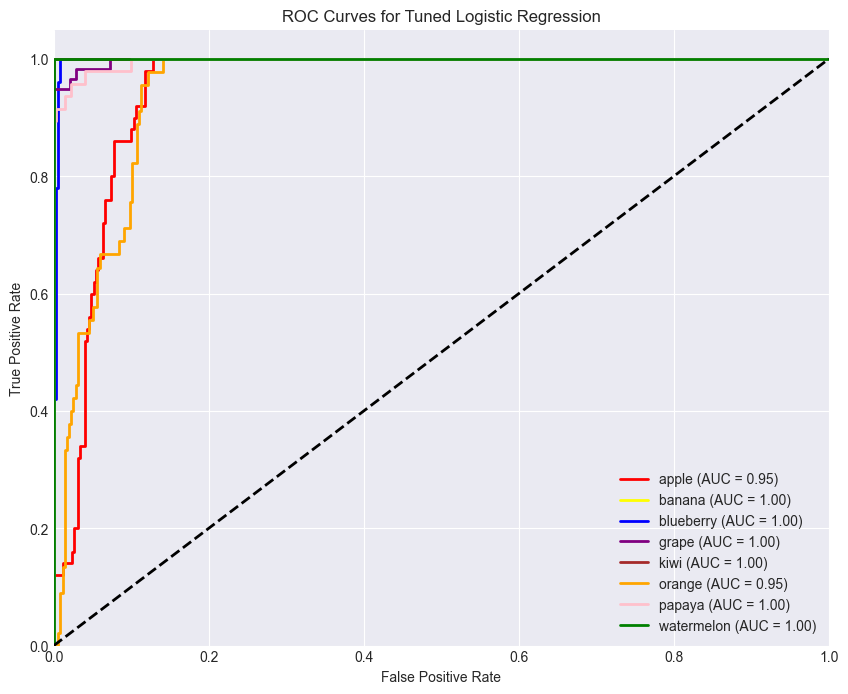

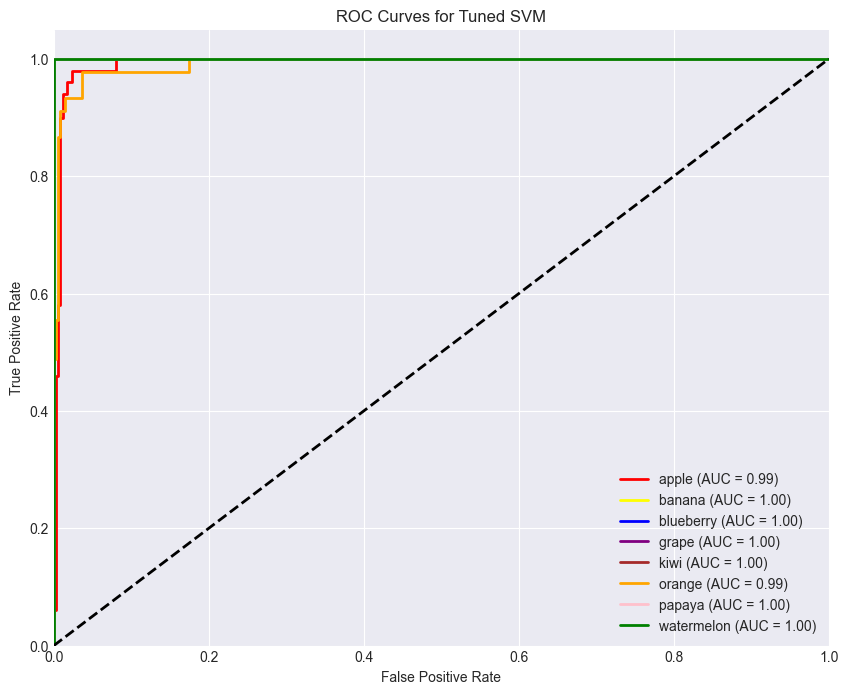

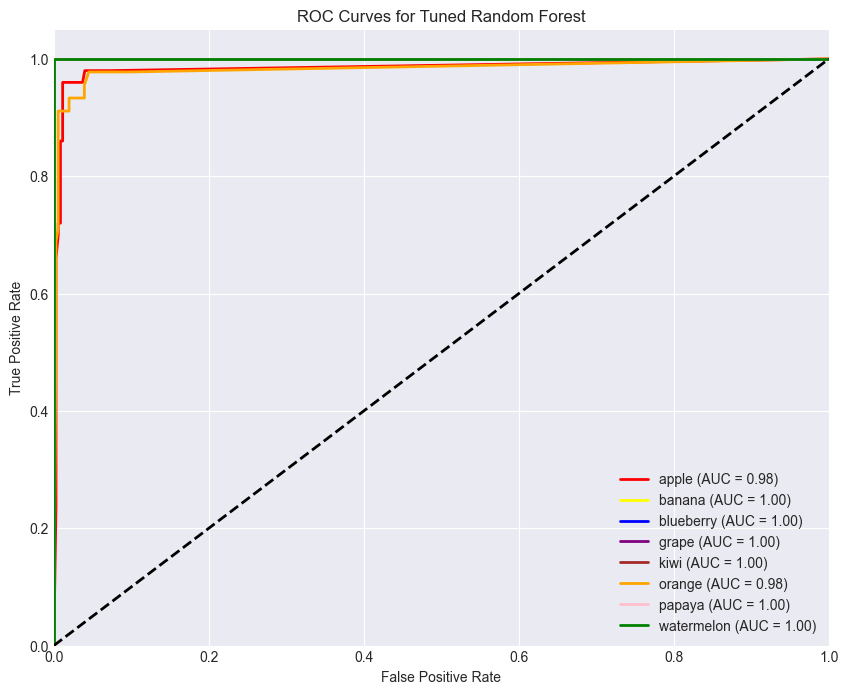

In [22]:
plt.style.use("seaborn-v0_8-darkgrid")

fruit_colors = {
    "apple": "red",
    "orange": "orange",
    "banana": "yellow",
    "grape": "purple",
    "kiwi": "brown",
    "papaya": "pink",
    "blueberry": "blue",
    "watermelon": "green",
}

# Binarize
y_test_bin = label_binarize(y_test, classes=range(len(le_fruit.classes_)))
n_classes = len(le_fruit.classes_)


def plot_roc_curves(model, X_test_scaled, y_test_bin, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Probabilities for each class
    y_score = model.predict_proba(X_test_scaled)

    # ROC and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = [fruit_colors[fruit] for fruit in le_fruit.classes_]
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=2,
            label=f"{le_fruit.classes_[i]} (AUC = {roc_auc[i]:.2f})",
        )

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves for {model_name}")
    plt.legend(loc="lower right")
    plt.show()


plot_roc_curves(
    lr_grid.best_estimator_, X_test_scaled, y_test_bin, "Tuned Logistic Regression"
)
plot_roc_curves(svm_grid.best_estimator_, X_test_scaled, y_test_bin, "Tuned SVM")
plot_roc_curves(
    rf_grid.best_estimator_, X_test_scaled, y_test_bin, "Tuned Random Forest"
)

## Матрица ошибок (Confusion matrix)

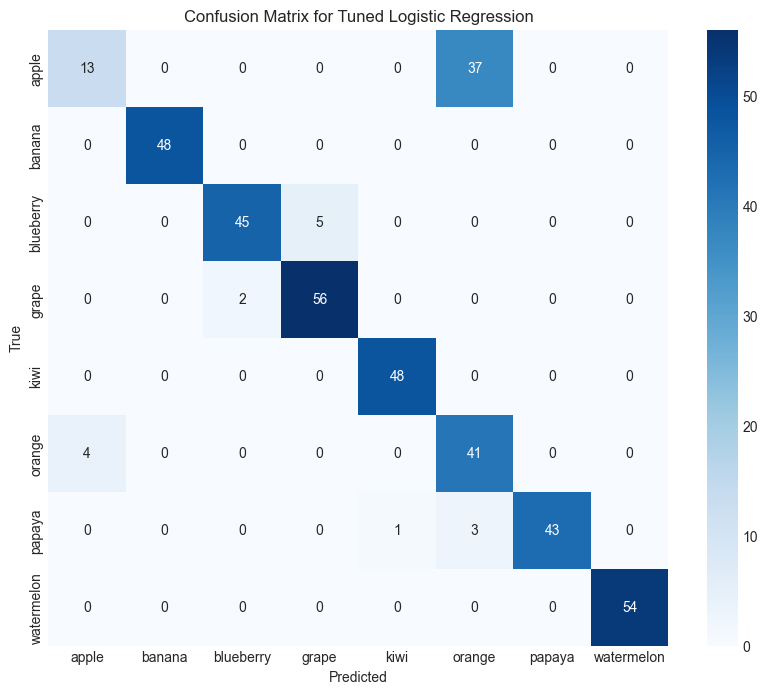

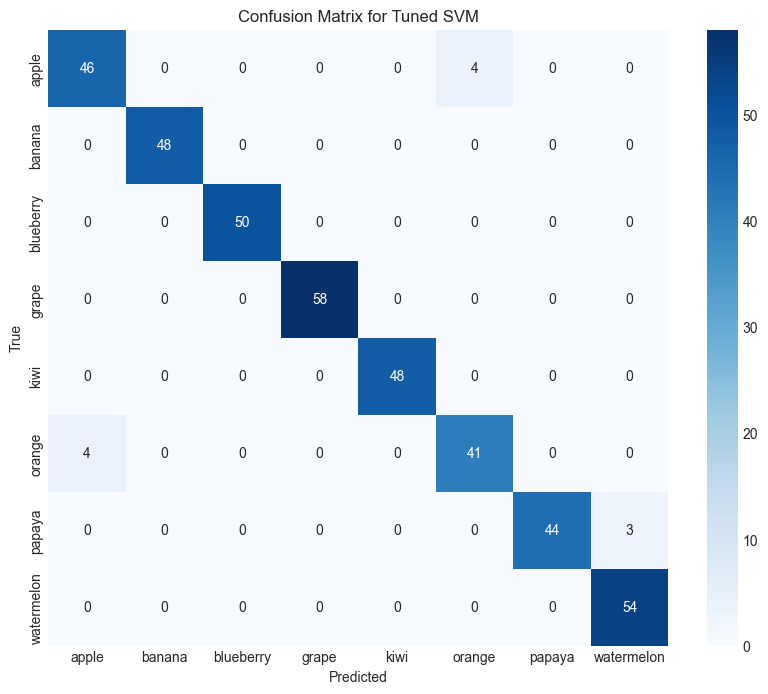

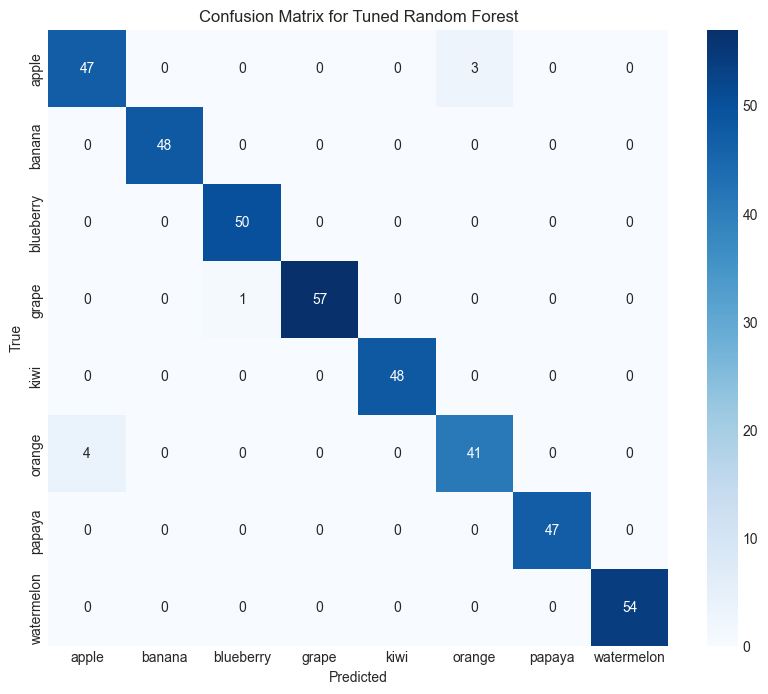

In [23]:
# Function to plot confusion matrix
def plot_confusion_matrix(model, X_test_scaled, y_test, model_name):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=le_fruit.classes_,
        yticklabels=le_fruit.classes_,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


# Plot confusion matrices for each tuned model
plot_confusion_matrix(
    lr_grid.best_estimator_, X_test_scaled, y_test, "Tuned Logistic Regression"
)
plot_confusion_matrix(svm_grid.best_estimator_, X_test_scaled, y_test, "Tuned SVM")
plot_confusion_matrix(
    rf_grid.best_estimator_, X_test_scaled, y_test, "Tuned Random Forest"
)

## Снижение размерности с помощью PCA

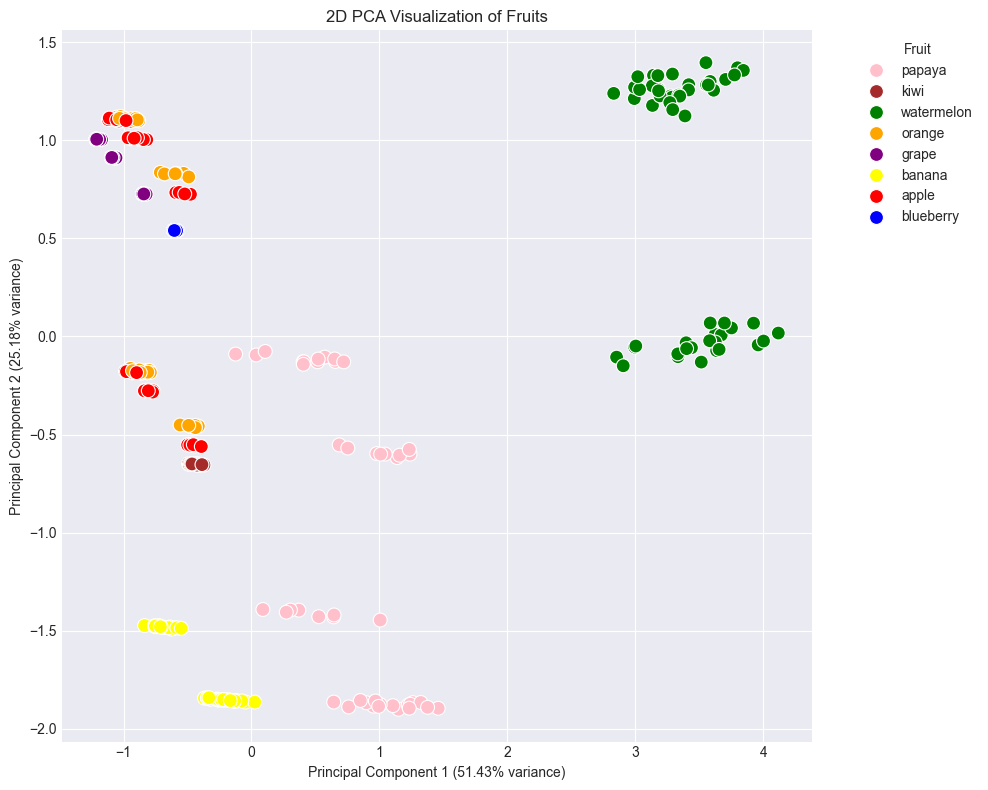

Explained Variance Ratio: [0.51428642 0.25182528]
Total Variance Explained: 0.7661116978605929


In [24]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"])
pca_df["fruit"] = le_fruit.inverse_transform(y_test)

# Plot with custom colors
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", hue="fruit", data=pca_df, palette=fruit_colors, s=100)
plt.title("2D PCA Visualization of Fruits")
plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
plt.legend(title="Fruit", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Print explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Variance Explained:", sum(pca.explained_variance_ratio_))

## Визуализация результатов

### Кривые ROC

Кривые ROC показывают способность каждой модели различать классы фруктов. Random Forest и SVM демонстрируют высокие значения AUC (близкие к 1.0), что подтверждает их превосходную производительность.

### Матрицы ошибок

Матрицы ошибок иллюстрируют точность предсказаний. Random Forest имеет наименьшее количество ошибок, особенно для сложных классов, таких как яблоки.

### 2D PCA визуализация

PCA показывает распределение фруктов в двумерном пространстве. Хорошо разделены крупные фрукты (арбуз) и мелкие (виноград, голубика), но яблоки и апельсины частично пересекаются из-за схожих характеристик.
